# **Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz
import graphviz

ImportError: Unable to import required dependencies:
numpy: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

# **Data Cleaning**

In [ ]:
# read in csv as dataframe
df_salaries_uncleaned = pd.read_csv("data/Salary_Data.csv")

# drop null entries
df_salaries_cleaned = df_salaries_uncleaned.dropna()

# standardize the degree names
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Bachelor's Degree", "Bachelor's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Master's Degree", "Master's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("phD", "PhD")

# normalize data types
df_salaries_cleaned["Age"] = df_salaries_cleaned["Age"].astype("int")
df_salaries_cleaned["Years of Experience"] = df_salaries_cleaned["Years of Experience"].astype("int")

# drop duplicate entries
df_salaries_cleaned = df_salaries_cleaned.drop_duplicates()

# show data summary
df_salaries_cleaned.info()
df_salaries_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1786 entries, 0 to 6631
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1786 non-null   int32  
 1   Gender               1786 non-null   object 
 2   Education Level      1786 non-null   object 
 3   Job Title            1786 non-null   object 
 4   Years of Experience  1786 non-null   int32  
 5   Salary               1786 non-null   float64
dtypes: float64(1), int32(2), object(3)
memory usage: 83.7+ KB


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32,Male,Bachelor's,Software Engineer,5,90000.0
1,28,Female,Master's,Data Analyst,3,65000.0
2,45,Male,PhD,Senior Manager,15,150000.0
3,36,Female,Bachelor's,Sales Associate,7,60000.0
4,52,Male,Master's,Director,20,200000.0


# **Data Preprocessing**

In [ ]:
# separate categorical and numerical columns
categorical_columns = ["Gender", "Education Level", "Job Title"]
numerical_columns = ["Age", "Years of Experience"]

# separate the data into features and target values
X_data = df_salaries_cleaned[["Age", "Gender", "Education Level", "Job Title", "Years of Experience"]]
y_data = df_salaries_cleaned["Salary"]

# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# transform table to standardize columns
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="drop"
)

# **Linear Regression**

### Hyperparameter Tuning

In [ ]:
# create tuning pipeline
pipeline_lin_initial = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

# hyperparameters to tune
param_grid_lin = {
    "selectkbest__k": [1, 2, 3, 4, 5],
}

# create an exhaustive search using cross validation
grid_search_lin = GridSearchCV(pipeline_lin_initial, param_grid_lin, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search_lin.fit(X_data, y_data)

print("Best Features:", grid_search_lin.best_estimator_.feature_names_in_)

Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [ ]:
# create model pipeline
pipeline_lin_tuned = make_pipeline(
    ct,
    LinearRegression()
)

# train model on training data
pipeline_lin_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('linearregression', LinearRegression())])

### Model Evaluations

In [ ]:
# predict salaries on testing data
y_pred_linear = pipeline_lin_tuned.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_linear))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred_linear)))
print("R2 Score:", r2_score(y_test, y_pred_linear))

Mean Squared Error (MSE): 503620783.2494343
Root Mean Squared Error (RMSE): 22441.496903046245
R2 Score: 0.8231839739213134


### Model Visualizations

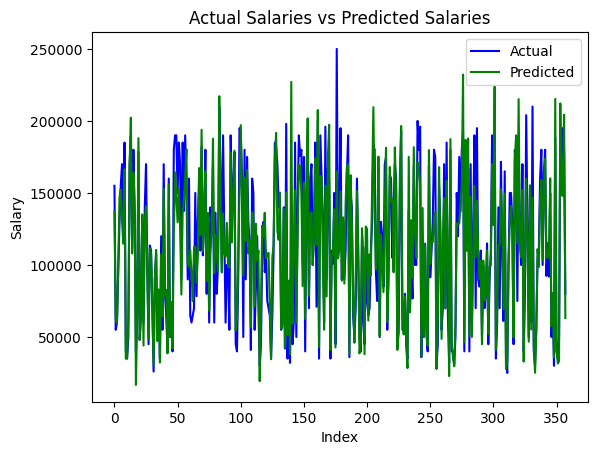

Text(0.5, 1.0, 'Absolute Error')

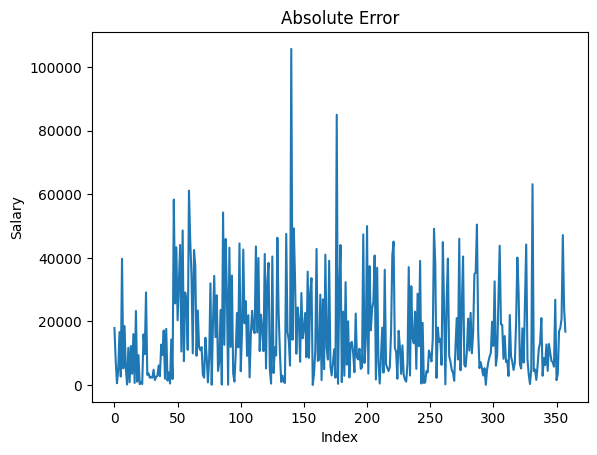

In [ ]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred_linear))]})
df_predicted["y"] = y_pred_linear

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.65)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.65)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

In [ ]:
# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred_linear

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.65)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error")

# **K-Nearest Neighbors**

### Hyperparameter Tuning

In [ ]:
# create tuning pipeline
pipeline_knn_initial = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    KNeighborsRegressor(metric="euclidean")
)

# hyperparameters to tune
param_grid_knn = {
    "selectkbest__k": [1, 2, 3, 4, 5],
    "kneighborsregressor__n_neighbors": [n for n in range(1, 10)]
}

# create an exhaustive search using cross validation
grid_search_knn = GridSearchCV(pipeline_knn_initial, param_grid_knn, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search_knn.fit(X_data, y_data)

print("Best N-Neighbors:", grid_search_knn.best_params_["kneighborsregressor__n_neighbors"])
print("Best Features:", grid_search_knn.best_estimator_.feature_names_in_)

Best N-Neighbors: 9
Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [ ]:
# create model pipeline
pipeline_knn_tuned = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=9, metric="euclidean")
)

# train model on training data
pipeline_knn_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=9))])

### Model Evaluations

In [ ]:
# predict salaries on testing data
y_pred_knn = pipeline_knn_tuned.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_knn))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("R2 Score:", r2_score(y_test, y_pred_knn))

Mean Squared Error (MSE): 419640080.43175393
Root Mean Squared Error (RMSE): 20485.11851153793
R2 Score: 0.8526687264045383


### Model Visualizations

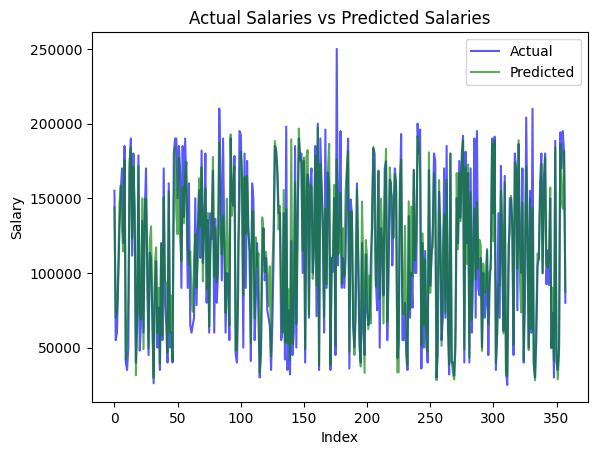

Text(0.5, 1.0, 'Absolute Error')

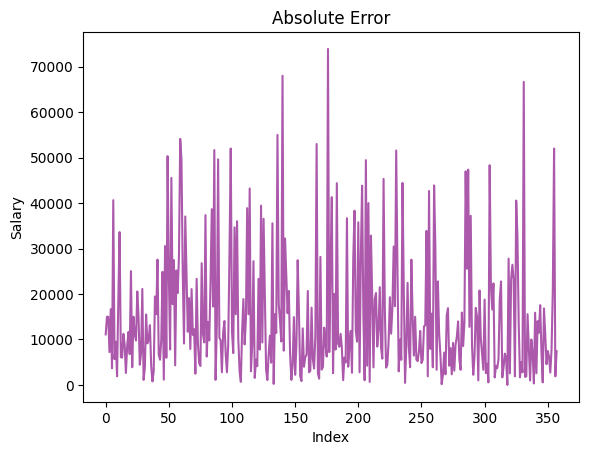

In [ ]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred_knn))]})
df_predicted["y"] = y_pred_knn

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.65)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.65)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

In [ ]:
# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred_knn

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.65)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error")

# **Random Forest**

### Hyperparameter Tuning

In [ ]:
# create model pipeline
pipeline_rf_initial = make_pipeline(
    ct,
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# Define the hyperparameters grid for the Random Forest
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200],  # Number of trees in the forest
    'randomforestregressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'randomforestregressor__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'randomforestregressor__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search_rf = GridSearchCV(pipeline_rf_initial, param_grid_rf, cv=5, scoring='r2', verbose=1)

# Assuming X_data and y_data are your features and target variable
grid_search_rf.fit(X_data, y_data)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)
print("Best Features:", grid_search_rf.best_estimator_.feature_names_in_)

### Model Training

In [ ]:
# create model pipeline
pipeline_rf_tuned = make_pipeline(
    ct,
    RandomForestRegressor(max_depth=30, min_samples_leaf=1, min_samples_split=5,n_estimators=200, random_state=42)
)

# train model on training data
pipeline_rf_tuned.fit(X=X_train, y=y_train)

### Model Evaluation

In [ ]:
# predict salaries on testing data
y_pred_rf = pipeline_rf_tuned.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_rf))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))

### Model Visualizations

In [ ]:
# function for extracting the features used from a pipeline's column transformer
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer."""
    output_features = []

    # loop through each transformer within the ColumnTransformer
    for name, estimator, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer
            continue
        # handle one-hot encoded features
        if hasattr(estimator, 'categories_'):
            for i, category in enumerate(estimator.categories_):
                output_features.extend([f"{columns[i]}_{cat}" for cat in category])
        # handle other transformers (e.g., scaling numerical features)
        else:
            output_features.extend(columns)

    return output_features

In [ ]:
random_forest_model = pipeline_rf_tuned.named_steps['randomforestregressor']
tree = random_forest_model.estimators_[0]

# extract feature names
transformed_feature_names = get_feature_names(pipeline_rf_tuned.named_steps['columntransformer'])

# export the tree to a DOT format
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=transformed_feature_names, 
                           filled=True, rounded=True, 
                           special_characters=True, max_depth=3)

# render the DOT data
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

In [ ]:
# Actual Salaries vs Predicted Salaries Graph

# table consisting of actual salaries
df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

# table consisting of predicted salaries
df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred_rf))]})
df_predicted["y"] = y_pred_rf

# create shared plot
ax = plt.gca()

# plot actual and predicted salaries
df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax, alpha=0.65)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax, alpha=0.65)

# set labels
ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries for Random Forest Model")

plt.show()

# Absolute Error Graph

# take the difference between each actual and predicted
df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred_rf

# apply absolute value
df_diff = df_diff.apply(abs)

# set labels
plt.plot(df_diff["x"], df_diff["y"], color="purple", alpha=0.65)
plt.xlabel("Index")
plt.ylabel("Salary")
plt.title("Absolute Error for Random Forest Model")